In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor, Pool

from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
#from  typing import
import warnings
warnings.filterwarnings('ignore')
from scipy import sparse
import scipy.stats as stats
#!pip install catboost optuna scikit-learn numpy
from joblib import dump, load

In [19]:
# Load dataset
df = pd.read_csv("data/cleaned_data_before_imputation.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56005 entries, 0 to 56004
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               56005 non-null  object 
 1   subtype            56005 non-null  object 
 2   bedroomCount       56005 non-null  float64
 3   toilet_and_bath    56005 non-null  float64
 4   province           56005 non-null  object 
 5   locality           56005 non-null  object 
 6   postCode           56005 non-null  int64  
 7   habitableSurface   56005 non-null  float64
 8   buildingCondition  48225 non-null  object 
 9   facedeCount        44638 non-null  float64
 10  hasTerrace         56005 non-null  bool   
 11  epcScore           52758 non-null  object 
 12  price              56005 non-null  float64
 13  totalParkingCount  56005 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(6)
memory usage: 5.6+ MB


In [20]:

# Define numeric and categorical columns
numeric_columns = ["bedroomCount", "toilet_and_bath", "habitableSurface", "facedeCount", "hasTerrace", "totalParkingCount"]
categorical_columns = ["type", "subtype", "province", "locality", "postCode", "buildingCondition", "epcScore"]

for col in categorical_columns:
    df[col] = df[col].astype(str)#.fillna("nan")


In [22]:

# Separate features and target
X = df[numeric_columns + categorical_columns]
y = df["price"]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56005 entries, 0 to 56004
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedroomCount       56005 non-null  float64
 1   toilet_and_bath    56005 non-null  float64
 2   habitableSurface   56005 non-null  float64
 3   facedeCount        44638 non-null  float64
 4   hasTerrace         56005 non-null  bool   
 5   totalParkingCount  56005 non-null  float64
 6   type               56005 non-null  object 
 7   subtype            56005 non-null  object 
 8   province           56005 non-null  object 
 9   locality           56005 non-null  object 
 10  postCode           56005 non-null  object 
 11  buildingCondition  56005 non-null  object 
 12  epcScore           56005 non-null  object 
dtypes: bool(1), float64(5), object(7)
memory usage: 5.2+ MB


In [ ]:

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=1234)


# Initialize CatBoostRegressor
catboost_model = CatBoostRegressor(
    iterations=550,
    learning_rate=0.3,
    depth=6,
    loss_function='MAE',
    verbose=0,                # Set to 100 to see logs every 100 iterations
    random_state=42
)

# Fit the model, specifying categorical features by name
catboost_model.fit(X_train, y_train, cat_features=categorical_columns)

# Make predictions
train_preds = catboost_model.predict(X_train)
test_preds = catboost_model.predict(X_test)

# Evaluation
print("CatBoost MSE (test):", mean_squared_error(y_test, test_preds))
print("R² (train):", r2_score(y_train, train_preds))
print("R² (test):", r2_score(y_test, test_preds))
print("MAE (train):", mean_absolute_error(y_train, train_preds))
print("MAE (test):", mean_absolute_error(y_test, test_preds))
print("MAPE (train):", mean_absolute_percentage_error(y_train, train_preds))
print("MAPE (test):", mean_absolute_percentage_error(y_test, test_preds))

# Save model
dump(catboost_model, 'model/catboost_price_prediction_model.joblib')


In [17]:
import pickle

# Save model
with open('model/catboost_price_prediction_model.pkl', 'wb') as f:
    pickle.dump(catboost_model, f)


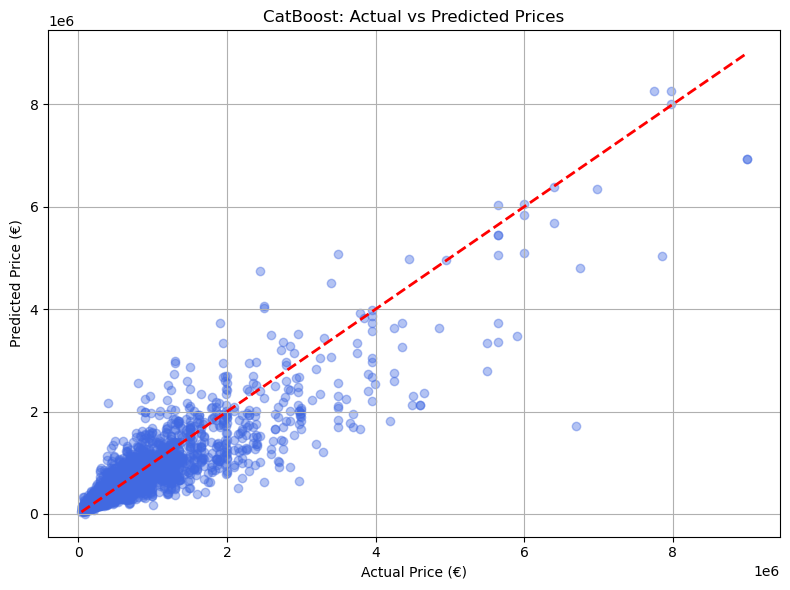

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_preds, alpha=0.4, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("CatBoost: Actual vs Predicted Prices")
plt.grid(True)
plt.tight_layout()
plt.show()

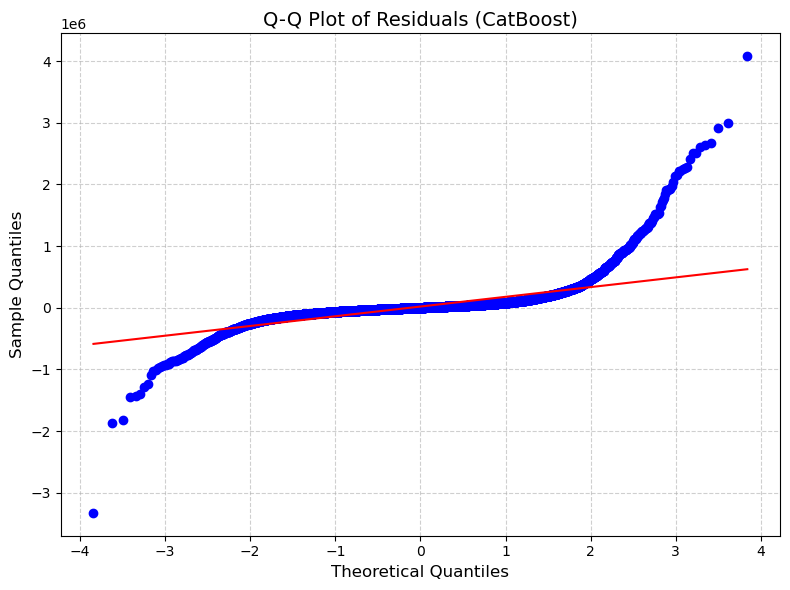

In [17]:
residuals = y_test - test_preds

# Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (CatBoost)", fontsize=14)
plt.xlabel("Theoretical Quantiles", fontsize=12)
plt.ylabel("Sample Quantiles", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [25]:
# Prepare CatBoost Pool objects
train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
val_pool = Pool(X_test, y_test, cat_features=categorical_columns)

# Initialize CatBoost model
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.15,
    depth=5,
    loss_function='RMSE',
    eval_metric='MAE',
    early_stopping_rounds=50,
    verbose=100,
    random_state=42
)

# Fit the model
catboost_model.fit(train_pool, eval_set=val_pool)

# Predictions
train_preds = catboost_model.predict(X_train)
test_preds = catboost_model.predict(X_test)

# Evaluation
print("\n📊 Evaluation Metrics:")
print("MSE (test):", mean_squared_error(y_test, test_preds))
print("R² (train):", r2_score(y_train, train_preds))
print("R² (test):", r2_score(y_test, test_preds))
print("MAE (train):", mean_absolute_error(y_train, train_preds))
print("MAE (test):", mean_absolute_error(y_test, test_preds))
print("MAPE (train):", mean_absolute_percentage_error(y_train, train_preds))
print("MAPE (test):", mean_absolute_percentage_error(y_test, test_preds))

0:	learn: 237055.6129901	test: 237202.1396328	best: 237202.1396328 (0)	total: 86.7ms	remaining: 1m 26s
100:	learn: 104718.3921843	test: 107124.5194975	best: 107124.5194975 (100)	total: 7.43s	remaining: 1m 6s
200:	learn: 98280.2016400	test: 102621.9907880	best: 102621.9907880 (200)	total: 12.8s	remaining: 51s
300:	learn: 94734.3474187	test: 100619.1037844	best: 100619.1037844 (300)	total: 18.2s	remaining: 42.2s
400:	learn: 92402.7535642	test: 99580.2528175	best: 99578.0299916 (399)	total: 26.6s	remaining: 39.7s
500:	learn: 90446.6854400	test: 98860.2344937	best: 98860.2344937 (500)	total: 32.1s	remaining: 32s
600:	learn: 88892.2077315	test: 98160.4671860	best: 98148.1463001 (595)	total: 37.2s	remaining: 24.7s
700:	learn: 87493.8444285	test: 97734.1138999	best: 97718.2615696 (693)	total: 42.3s	remaining: 18.1s
800:	learn: 86182.8652066	test: 97097.3182677	best: 97097.3182677 (800)	total: 47.5s	remaining: 11.8s
900:	learn: 85042.3759175	test: 96623.2755172	best: 96623.2755172 (900)	total: